In [1]:
#!kaggle competitions download -c tweet-sentiment-extraction

In [1]:
import pandas as pd
import numpy as np
import os

import emoji

import matplotlib.pyplot as plt

import urllib.request

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *


from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout, SimpleRNN, Flatten, Conv1D, MaxPooling1D
from keras.layers.core import Dense, Activation, Dropout


Using TensorFlow backend.


In [2]:
#urllib.request.urlretrieve("https://raw.githubusercontent.com/reejungkim/Natural-Language-Processing/master/tweet-sentiment-extraction/train.csv", filename="train.csv")
#train = pd.read_csv('train.csv',encoding='latin1')

train = pd.read_csv("https://raw.githubusercontent.com/reejungkim/Natural-Language-Processing/master/tweet-sentiment-extraction/train.csv", error_bad_lines=False)
test = pd.read_csv("https://raw.githubusercontent.com/reejungkim/Natural-Language-Processing/master/tweet-sentiment-extraction/test.csv", error_bad_lines=False)


In [3]:
train.head()

textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative

In [4]:
test.head()

textID                                               text sentiment
0  f87dea47db  Last session of the day  http://twitpic.com/67ezh   neutral
1  96d74cb729   Shanghai is also really exciting (precisely -...  positive
2  eee518ae67  Recession hit Veronique Branquinho, she has to...  negative
3  01082688c6                                        happy bday!  positive
4  33987a8ee5             http://twitpic.com/4w75p - I like it!!  positive

# Data exploration

## checking for null values

In [6]:
train.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [7]:
train.loc[pd.isnull(train.text)]

textID text selected_text sentiment
314  fdb77c3752  NaN           NaN   neutral

## drop null

In [5]:
train.dropna(inplace=True)

## count of unique values

In [6]:
train.sentiment.unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [7]:
train.shape, test.shape

((27480, 4), (3534, 3))

In [8]:
train.pivot_table(index='sentiment', values='textID', 
                  aggfunc='count', margins=True)


textID
sentiment        
negative     7781
neutral     11117
positive     8582
All         27480

In [9]:
train.pivot_table(index='sentiment', values='textID', 
                 aggfunc = lambda x: x.count()/train['sentiment'].count())


textID
sentiment          
negative   0.283151
neutral    0.404549
positive   0.312300

# Feature engineering

In [11]:
df = pd.concat([train, test])
train.shape, test.shape, df.shape

((27480, 4), (3534, 3), (31014, 4))

## URL 

In [12]:
def find_url(string): 
    text = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',string)
    if text!=[]:
        return "".join(text)
    return None

In [13]:
df['url']=df['text'].apply(lambda x:find_url(x))

In [15]:
df.loc[pd.notnull(df.url)][:3]

textID                                               text  \
5   28b57f3990  http://www.dothebouncy.com/smf - some shameles...   
17  919fa93391  i`ve been sick for the past few days  and thus...   
35  4f5267ad70  Thats it, its the end. Tears for Fears vs Eric...   

                                        selected_text sentiment  \
5   http://www.dothebouncy.com/smf - some shameles...   neutral   
17                                               sick  negative   
35             Thats it, its the end. Tears for Fears   neutral   

                               url  
5   http://www.dothebouncy.com/smf  
17       http://tinyurl.com/mnf4kw  
35            http://bit.ly/2Hpbg4

## Emoticons

In [17]:
ex = "😍 lol 😆 😂 "
emoji.demojize(ex)

':smiling_face_with_heart-eyes: lol :grinning_squinting_face: :face_with_tears_of_joy: '

In [18]:
re.findall(':(.*?):', emoji.demojize(ex) )  #<-mac
#re.findall( r'\:(.*?)\:', emoji.demojize(ex) )  <- window

['smiling_face_with_heart-eyes',
 'grinning_squinting_face',
 'face_with_tears_of_joy']

emoji.UNICODE_EMOJI

In [19]:
def extract_emojis(string):
    emoticon = "".join(c for c in string if c in emoji.UNICODE_EMOJI)
    if emoticon!="":
        return emoticon
    return None

In [20]:
extract_emojis( "😊😳😏😁")

'😊😳😏😁'

In [21]:
extract_emojis('text without emojis')

In [22]:
df['emoji']=df['text'].apply(lambda x: extract_emojis(x))

In [23]:
df.loc[pd.notnull(df.emoji)]

Empty DataFrame
Columns: [textID, text, selected_text, sentiment, url, emoji]
Index: []

In [24]:
df.head(2)

textID                                            text  \
0  cb774db0d1             I`d have responded, if I were going   
1  549e992a42   Sooo SAD I will miss you here in San Diego!!!   

                         selected_text sentiment   url emoji  
0  I`d have responded, if I were going   neutral  None  None  
1                             Sooo SAD  negative  None  None

## Text preparation

### stopwords: words which does not add much meaning to a sentence

In [25]:
#nltk.download('stopwords') <- if error raises on nltk stopwords

stops = set(stopwords.words('english'))
#stops

### stem extraction - Lemmatizing words

In [26]:
words =['fly', 'flies', 'flew', 'flown']

In [27]:
from nltk.stem import PorterStemmer, LancasterStemmer, SnowballStemmer

#types of stemmers
stemmerS = SnowballStemmer('english')  
stemmerP = PorterStemmer()
stemmerL = LancasterStemmer()

In [28]:
OutputSnowball=[stemmerS.stem(word) for word in words]
OutputPorter=[stemmerP.stem(word) for word in words]
OutputLancaster=[stemmerL.stem(word) for word in words]

print("using Snowball stemmer: ", OutputSnowball)
print("using Porter stemmer: ", OutputPorter)
print("using Lancaster stemmer: ", OutputLancaster)

using Snowball stemmer:  ['fli', 'fli', 'flew', 'flown']
using Porter stemmer:  ['fli', 'fli', 'flew', 'flown']
using Lancaster stemmer:  ['fly', 'fli', 'flew', 'flown']


In [29]:
from nltk.stem import WordNetLemmatizer
lm = WordNetLemmatizer()
#nltk.download('wordnet')

In [30]:
Output=[lm.lemmatize(word, pos="v") for word in words]
print("using Lemmatizer: " , Output)

using Lemmatizer:  ['fly', 'fly', 'fly', 'fly']


# Tokenizer

In [31]:
def language_preprocessor(string):
    text =  re.sub('[^a-zA-Z]', ' ', string) #replace non-english with blank
    text = text.lower().split() #decapitalize texts
    text = [word for word in text if not word in stops] #remove stopword
    text = [lm.lemmatize(word) for word in text]  #lemmatization of texts
    return text #' '.join(text)
    

In [32]:
df['text processed'] = df['text'].apply(lambda x: language_preprocessor(x)) 


In [34]:
df.head(3)

textID                                            text  \
0  cb774db0d1             I`d have responded, if I were going   
1  549e992a42   Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                       my boss is bullying me...   

                         selected_text sentiment   url emoji  \
0  I`d have responded, if I were going   neutral  None  None   
1                             Sooo SAD  negative  None  None   
2                          bullying me  negative  None  None   

                  text processed  
0             [responded, going]  
1  [sooo, sad, miss, san, diego]  
2                [bos, bullying]

# Commonly used words for each sentiment type

In [44]:
positive = df[df.sentiment=='positive']
negative = df[df.sentiment=='negative']
neutral = df[df.sentiment=='neutral']

In [45]:
from collections import Counter

def common_words(df, col, n):
    counts = Counter([item for sublist in df[col] for item in sublist])
    common_words = pd.DataFrame(counts.most_common(n))
    common_words.columns =['Word','count']
    return common_words
    

## positive

In [46]:
common_words_positive  = common_words(positive, 'text processed', 10)
common_words_positive

Word  count
0     day   1530
1    good   1214
2    love   1096
3   happy    957
4  mother    753
5  thanks    645
6   great    539
7       u    498
8    like    486
9    http    477

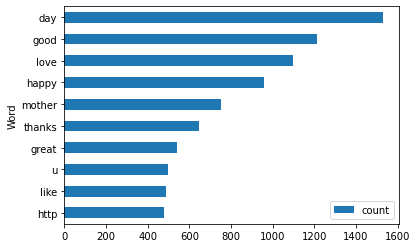

In [47]:
common_words_positive.set_index('Word').sort_values(
    by='count', ascending=True).plot(kind='barh')

In [48]:
import plotly.express as px

px.treemap(common_words_positive, 
           path=['Word'], values='count',
           title='Most commonly used Positive Words',
          width=400, height=400)

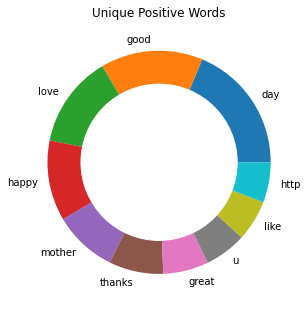

In [49]:
import matplotlib.pyplot as plt
#from palettable.colorbrewer.qualitative import Pastel1_7

plt.figure(figsize=(5,7))
my_circle=plt.Circle((0,0), 0.7, color='white')


plt.pie(common_words_positive['count'], 
        labels=common_words_positive.Word) #,colors=Pastel1_7.hex_colors)

p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Unique Positive Words')
plt.show()

### visualization with word cloud

In [50]:
common_words_positive  = common_words(positive, 'text processed', 100)

In [51]:
common_words_positive.set_index("Word")['count']

Word
day         1530
good        1214
love        1096
happy        957
mother       753
            ... 
birthday     116
sleep        116
x            115
bit          115
sure         114
Name: count, Length: 100, dtype: int64

In [52]:
words = common_words_positive.set_index("Word")['count'].to_dict()
words

{'day': 1530,
 'good': 1214,
 'love': 1096,
 'happy': 957,
 'mother': 753,
 'thanks': 645,
 'great': 539,
 'u': 498,
 'like': 486,
 'http': 477,
 'hope': 463,
 'get': 435,
 'lol': 396,
 'today': 396,
 'time': 391,
 'fun': 388,
 'nice': 387,
 'night': 387,
 'one': 360,
 'go': 358,
 'got': 354,
 'com': 346,
 'really': 333,
 'morning': 328,
 'wish': 324,
 'going': 320,
 'see': 320,
 'mom': 317,
 'new': 314,
 'awesome': 308,
 'well': 303,
 'know': 303,
 'haha': 298,
 'work': 298,
 'much': 297,
 'back': 288,
 'thank': 282,
 'best': 252,
 'better': 248,
 'oh': 245,
 'would': 236,
 'think': 226,
 'home': 222,
 'im': 220,
 'make': 217,
 'look': 205,
 'cool': 202,
 'want': 201,
 'amazing': 199,
 'twitter': 196,
 'friend': 191,
 'tonight': 188,
 'tomorrow': 185,
 'last': 184,
 'weekend': 183,
 'could': 179,
 'thing': 179,
 'still': 177,
 'week': 177,
 'though': 171,
 'wait': 165,
 'say': 161,
 'yay': 159,
 'come': 159,
 'everyone': 157,
 'need': 156,
 'guy': 155,
 'twitpic': 153,
 'right': 150,


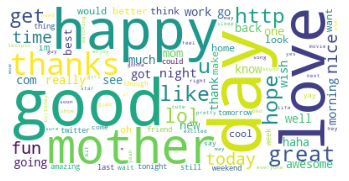

In [53]:
from wordcloud import WordCloud
wc = WordCloud(background_color='white', width=400, height=200)
wordcloud = wc.generate_from_frequencies(words)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## negative

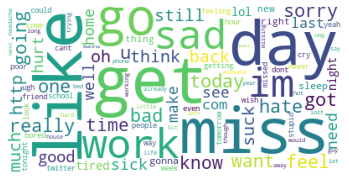

In [54]:
common_words_negative  = common_words(negative, 'text processed', 100)
words_negative = common_words_negative.set_index("Word")['count'].to_dict()

wordcloud = wc.generate_from_frequencies(words_negative)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

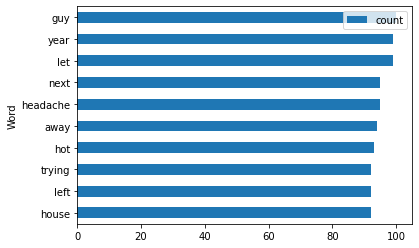

In [55]:
common_words_negative.set_index('Word').sort_values(
    by='count', ascending=True).head(10).plot(kind='barh')

# Vectorizing text.

In [58]:
df.head(3)

textID                                            text  \
0  cb774db0d1             I`d have responded, if I were going   
1  549e992a42   Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                       my boss is bullying me...   

                         selected_text sentiment   url emoji  \
0  I`d have responded, if I were going   neutral  None  None   
1                             Sooo SAD  negative  None  None   
2                          bullying me  negative  None  None   

                  text processed  
0             [responded, going]  
1  [sooo, sad, miss, san, diego]  
2                [bos, bullying]

In [59]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer() #oov_token="<OOV>") #num_words=1000)
tokenizer.fit_on_texts(df['text processed'])

In [60]:
print(tokenizer.word_index)

{'day': 1, 'good': 2, 'get': 3, 'like': 4, 'go': 5, 'http': 6, 'u': 7, 'love': 8, 'work': 9, 'today': 10, 'got': 11, 'going': 12, 'time': 13, 'one': 14, 'lol': 15, 'happy': 16, 'know': 17, 'com': 18, 'back': 19, 'really': 20, 'im': 21, 'want': 22, 'see': 23, 'night': 24, 'mother': 25, 'think': 26, 'new': 27, 'home': 28, 'well': 29, 'oh': 30, 'still': 31, 'thanks': 32, 'much': 33, 'need': 34, 'miss': 35, 'hope': 36, 'feel': 37, 'great': 38, 'last': 39, 'make': 40, 'morning': 41, 'haha': 42, 'wish': 43, 'twitter': 44, 'fun': 45, 'week': 46, 'would': 47, 'tomorrow': 48, 'thing': 49, 'sad': 50, 'tonight': 51, 'sorry': 52, 'bad': 53, 'right': 54, 'look': 55, 'come': 56, 'friend': 57, 'gonna': 58, 'nice': 59, 'though': 60, 'say': 61, 'yeah': 62, 'better': 63, 'mom': 64, 'sleep': 65, 'way': 66, 'weekend': 67, 'could': 68, 'getting': 69, 'people': 70, 'bit': 71, 'bed': 72, 'hour': 73, 'next': 74, 'twitpic': 75, 'hate': 76, 'school': 77, 'guy': 78, 'watching': 79, 'show': 80, 'dont': 81, 'yes':

In [61]:
vocab_size = len(tokenizer.word_index) +1

In [81]:
train.shape, df.shape

((27480, 4), (31014, 7))

In [121]:
X_data = df['text processed']
X_data

0                                      [responded, going]
1                           [sooo, sad, miss, san, diego]
2                                         [bos, bullying]
3                               [interview, leave, alone]
4                    [son, put, release, already, bought]
                              ...                        
3529                              [im, tired, sleep, try]
3530    [alone, old, house, thanks, net, keep, alive, ...
3531    [know, mean, little, dog, sinking, depression,...
3532    [sutra, next, youtube, video, gonna, love, video]
3533    [http, twitpic, com, woj, omgssh, ang, cute, n...
Name: text processed, Length: 31014, dtype: object

In [122]:
X_data = tokenizer.texts_to_sequences(X_data)
#x_train = np.asarray(x_train)
X_data = np.asarray(X_data)



In [124]:
max_len = max(len(item) for item in X_data)
print(max_len)

25


In [125]:
from keras.preprocessing.sequence import pad_sequences

X_data = pad_sequences(x_train, maxlen=max_len, padding='post', truncating='post')
np.asarray(X_data)

array([[ 6885,    12,     0, ...,     0,     0,     0],
       [  311,    50,    35, ...,     0,     0,     0],
       [ 1242,  9974,     0, ...,     0,     0,     0],
       ...,
       [   17,   160,    92, ...,     0,     0,     0],
       [24202,    74,   407, ...,     0,     0,     0],
       [    6,    75,    18, ...,     0,     0,     0]], dtype=int32)

from tensorflow.keras.utils import to_categorical
x_train = to_categorical(x_train)
x_train

y_train = train.sentiment.replace({"neutral":0, 'positive': 1, 'negative':-1})
y_train = y_train.values

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
#integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(train.sentiment)

enc = OneHotEncoder()
onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded)

y_train = onehot_encoded

from keras.utils import to_categorical
to_categorical(integer_encoded)

In [132]:
x_train = X_data[:27480]
x_val = X_data[27480:]

In [133]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(df.sentiment)
encoded_Y = encoder.transform(df.sentiment)
# convert integers to dummy variables (i.e. one hot encoded)
y_train = np_utils.to_categorical(encoded_Y)[:27480]

y_val = np_utils.to_categorical(encoded_Y)[27480:]

In [134]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((27480, 25), (27480, 3), (3534, 25), (3534, 3))

In [135]:
len(x_train[0])

25

In [155]:
#define the model
model = Sequential()
model.add(Embedding(vocab_size, 50))
model.add(SimpleRNN(10))
model.add(Dense(7, input_dim=x_train.shape[1], activation='relu', kernel_initializer='he_normal'))
model.add(Dense(3, activation='sigmoid'))

# compile the keras model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# fit the keras model on the dataset
history = model.fit(x_train, y_train, epochs=15, batch_size=3000, verbose=2)

/Users/reejungkim/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning:

Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.



Epoch 1/15
 - 2s - loss: 1.0948 - accuracy: 0.3746
Epoch 2/15
 - 1s - loss: 1.0845 - accuracy: 0.4072
Epoch 3/15
 - 1s - loss: 1.0670 - accuracy: 0.4721
Epoch 4/15
 - 1s - loss: 1.0248 - accuracy: 0.5357
Epoch 5/15
 - 1s - loss: 0.9655 - accuracy: 0.5910
Epoch 6/15
 - 1s - loss: 0.9101 - accuracy: 0.6423
Epoch 7/15
 - 1s - loss: 0.8606 - accuracy: 0.6965
Epoch 8/15
 - 1s - loss: 0.8151 - accuracy: 0.7333
Epoch 9/15
 - 1s - loss: 0.7743 - accuracy: 0.7576
Epoch 10/15
 - 1s - loss: 0.7378 - accuracy: 0.7766
Epoch 11/15
 - 1s - loss: 0.7037 - accuracy: 0.7905
Epoch 12/15
 - 1s - loss: 0.6718 - accuracy: 0.8095
Epoch 13/15
 - 1s - loss: 0.6407 - accuracy: 0.8210
Epoch 14/15
 - 1s - loss: 0.6135 - accuracy: 0.8336
Epoch 15/15
 - 1s - loss: 0.5874 - accuracy: 0.8388


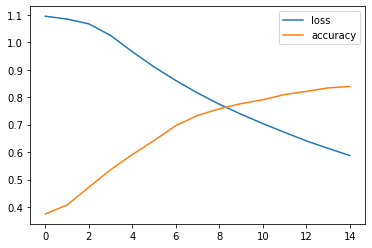

In [156]:
for name, value in history.history.items():
    plt.plot(value, label=name)
plt.legend()
plt.show()

In [157]:
# evaluate the keras model
_, accuracy = model.evaluate(x_train, y_train, verbose=0)
print('Accuracy based on training data set: %.2f' % (accuracy*100))

Accuracy based on training data set: 85.45


In [158]:
_, accuracy = model.evaluate(x_val, y_val, verbose=0)
print('Accuracy based on validation data: %.2f' % (accuracy*100))

Accuracy based on validation data: 44.91




# define baseline model
def baseline_model():
    #model architecture)
    #input_tensor = Input(shape=(27480, 10 ))
    model = Sequential()
    model.add(Embedding(vocab_size, 50))
    model.add(SimpleRNN(7))
    #model.add(Dense(5, activation="relu", kernel_initializer="uniform") )
    #model.add(Dense(5, input_dim=5, activation="relu", kernel_initializer="uniform"))
    model.add(Dense(3, activation='sigmoid'))
    # Compile model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model


from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(5, activation="relu", kernel_initializer="uniform", input_shape=((5,  )) ))
#model.add(Dense(5, input_dim=5, activation="relu", kernel_initializer="uniform"))
model.add(Dense(1, activation='sigmoid'))

In [72]:
y_train.shape, x_train.shape

((27480, 3), (27480, 25))

estimator = KerasClassifier(build_fn=baseline_model, epochs=4, batch_size=5000, verbose=1)
kfold = KFold(n_splits=2, shuffle=True)
results = cross_val_score(estimator, x_train, y_train, cv=kfold)


print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(x_train, y_train, 
                    epochs=15, batch_size=5000, verbose=0)

results = model.evaluate(x_train, y_train)
results

loss_score, accuracy_score = model.evaluate(x_train, y_train, verbose=0)
model.reset_states()
print('Train Loss Score: {:.2f}'.format(loss_score))
print('Train Accuracy Score: {:.2f}%'.format(accuracy_score*100))

In [84]:
def predict_sentiment(text):
    text = language_preprocessor(text)
    tokenizer.fit_on_texts(text)
    text = tokenizer.texts_to_sequences([text])
    text = pad_sequences(text, maxlen=max_len, padding='post', truncating='post')
    #return text
    predict = model.predict(text)
    predict = predict.argmax(axis=-1)
    #predict_labels = np.argmax(predict, axis=1) 
    return predict

In [85]:
test_text = "i really love it! it is such a great day"

In [86]:
predict_sentiment(test_text)

array([0])

test['prediction']=test['text'].apply(lambda x: predict_sentiment(x))